In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub

# Download latest version
path = kagglehub.dataset_download("imonbilk/industry-biscuit-cookie-dataset")

print("Path to dataset files:", path)
from google.colab import drive
drive.mount('/content/drive')

100%|██████████| 43.5M/43.5M [00:00<00:00, 81.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/imonbilk/industry-biscuit-cookie-dataset/versions/2
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Anomaly Detection on Biscuit DataSet**

**Anomaly detection**: classifying images as The Industrial Biscuits (Cookie) dataset is our internal dataset designed for the anomaly detection task, which captures Tarallini biscuits. It contains 1225 samples in four classes with the following structure:

* **Defect_No**: No defect (474 captions)  - **classCode: 0**
* **Defect_Shape**: not complete (465 captions)  - **classCode: 1**
* **Defect_Object**: strange object (158 captions)  - **classCode: 2**
* **Defect_Color**: color defect (128 captions)  - **classCode: 3**


## Description of the Dataset
The dataset consists of images of biscuits, with each image annotated with a defect class. The dataset is structured as follows:

**Images Directory:** Contains all the images of biscuits.

**Annotations File:** A CSV file where each row corresponds to an image and contains the following columns:

**file:** The filename of the image.

**classDescription:** The defect category of the biscuit (e.g., Defect_Shape).

**classCode:** A numerical code representing the defect category.



The dataset is split into training and validation sets with the following distribution:

**Training Set:** 3920 images belonging to 4 classes.

**Validation Set:** 980 images belonging to 4 classes.


## Motivation of the Work
The primary motivation behind this project is to automate the quality control process in biscuit manufacturing by detecting anomalies such as shape defects. This automation can significantly reduce human effort, improve consistency, and increase the efficiency of the production line.

## Why This Problem?
Detecting defects in biscuits manually is time-consuming, prone to human error, and inconsistent. Automating this process ensures higher accuracy, consistency, and speed, leading to better quality control and cost savings.

## Why This Architecture/Algorithm?
A Convolutional Neural Network (CNN) architecture is chosen due to its proven effectiveness in image classification and object detection tasks. CNNs can automatically learn features from images, making them suitable for detecting complex patterns such as defects in biscuit shapes.

## Methodology

### Data Preparation:

#### Data Augmentation:

Applied transformations such as rotation, width and height shifts, shear, zoom, and horizontal flips to increase the diversity of the training data.
Rescaling: Normalized pixel values to a range of 0 to 1.
Validation Split: Used 20% of the data for validation to monitor the model's performance.
Model Architecture:

#### Convolutional Layers:

Used multiple convolutional layers with ReLU activation to extract features from the images.

#### Pooling Layers:

Applied max pooling to reduce the spatial dimensions and retain the most important features.
#### Fully Connected Layers:

Flattened the feature maps and used dense layers for classification.
#### Dropout:

Added dropout layers to prevent overfitting.
#### Training:

Compiled the model with the Adam optimizer and categorical cross-entropy loss function.
Trained the model using the training data generator, with a set number of epochs and steps per epoch.
Validated the model using the validation data generator to evaluate its performance.
Flow of the Work

Data Loading:

Load images and annotations.

Data Augmentation: Apply transformations to increase data diversity.

Model Definition: Define the CNN architecture.

Model Compilation: Compile the model with the appropriate optimizer and loss function.

Training: Train the model using the training dataset.

Validation: Validate the model using the validation dataset.

Evaluation: Evaluate the model’s performance and analyze the results.

In [2]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [5]:
# Set the base directory path
base_dir = '/content/drive/MyDrive/IMCS/IndustryBiscuit'
train_path = os.path.join(path, 'IndustryBiscuit')
# Set the paths for the images and annotations
images_dir = os.path.join(train_path, 'Images')
annotations_path = os.path.join(train_path, 'Annotations.csv')
annotations_path, images_dir

('/root/.cache/kagglehub/datasets/imonbilk/industry-biscuit-cookie-dataset/versions/2/IndustryBiscuit/Annotations.csv',
 '/root/.cache/kagglehub/datasets/imonbilk/industry-biscuit-cookie-dataset/versions/2/IndustryBiscuit/Images')

In [6]:
# Load the annotations CSV file
annotations = pd.read_csv(annotations_path)
annotations

,file,classDescription,classCode
0,0001.jpg,Defect_Shape,1
1,0002.jpg,Defect_Shape,1
2,0003.jpg,Defect_Shape,1
3,0004.jpg,Defect_Shape,1
4,0005.jpg,Defect_Shape,1
...,...,...,...
4895,4896.jpg,Defect_Shape,1
4896,4897.jpg,Defect_Shape,1
4897,4898.jpg,Defect_Shape,1
4898,4899.jpg,Defect_Shape,1


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% validation split
)

batch_size = 16

# Create generators for training and validation sets
train_generator = datagen.flow_from_dataframe(
    annotations,
    directory=images_dir,
    x_col='file',  # File names column in Annotations.csv
    y_col='classDescription',     # Class Label column in Annotations.csv
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    annotations,
    directory=images_dir,
    x_col='file',
    y_col='classDescription',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 3920 validated image filenames belonging to 4 classes.
Found 980 validated image filenames belonging to 4 classes.


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
import tensorflow as tf


# Define the model architecture
model = Sequential([
    Input(shape=(150, 150, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(train_generator.class_indices), activation='softmax')  # Number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
with tf.device('/GPU:0'):
    model.fit(train_generator, epochs=30, validation_data=validation_generator)


# Evaluate the model
validation_loss, validation_accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {validation_accuracy*100:.2f}%')


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 37s 128ms/step - accuracy: 0.4540 - loss: 1.1546 - val_accuracy: 0.7837 - val_loss: 0.7299
Epoch 2/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 28s 115ms/step - accuracy: 0.7985 - loss: 0.6133 - val_accuracy: 0.8622 - val_loss: 0.5031
Epoch 3/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 27s 112ms/step - accuracy: 0.8481 - loss: 0.4883 - val_accuracy: 0.8735 - val_loss: 0.4014
Epoch 4/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 27s 108ms/step - accuracy: 0.8869 - loss: 0.3727 - val_accuracy: 0.9020 - val_loss: 0.3039
Epoch 5/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 27s 109ms/step - accuracy: 0.8956 - loss: 0.3417 - val_accuracy: 0.9245 - val_loss: 0.2422
Epoch 6/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 27s 111ms/step - accuracy: 0.9042 - loss: 0.2911 - val_accuracy: 0.8561 - val_loss: 0.3825
Epoch 7/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 28s 114ms/step - accuracy: 0.8928 - loss: 0.3318 - val_accuracy: 0.8959 - val_loss: 0.3055
Epoch 8/30
245/245 ━━━━━━━━━━━━━━━━━━━━ 28s 114ms/step - accuracy: 0.8806 - loss: 0

In [9]:
model.save(base_dir+'/biscuit_anomaly_detector.keras')


In [10]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = load_model(base_dir+'/biscuit_anomaly_detector.keras')

# Preprocess the input image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))  # Resize to the target size
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match the model's input shape
    img_array /= 255.0  # Normalize to the range [0, 1]
    return img, img_array  # Return both original image and processed array

# Create a dictionary to map class indices to class descriptions
class_indices = train_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}

# Make predictions and visualize the image
def make_prediction(model, img_path):
    img, img_array = preprocess_image(img_path)  # Get both original and processed images


    # Make prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]  # Get the class index
    predicted_label = class_labels[predicted_class]  # Get the class label
    print(f'Predicted class description: {predicted_label}')

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.title("Input Image")
    plt.show()




1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 575ms/step
Predicted class description: Defect_Shape


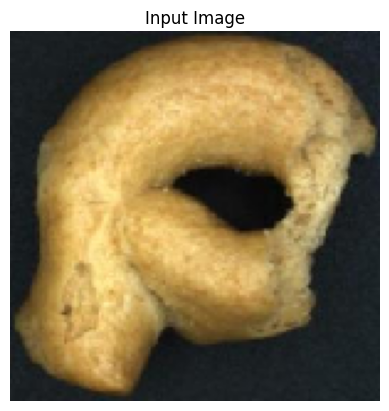

In [11]:
# Example usage
img_path = base_dir+'/Images/0001.jpg'
make_prediction(model, img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted class description: Defect_Object


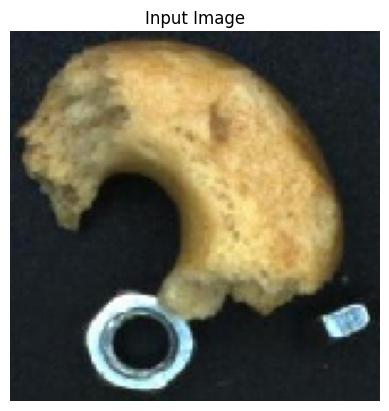

In [12]:
# Example usage
img_path = base_dir+'/Images/3272.jpg'
make_prediction(model, img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted class description: Defect_Color


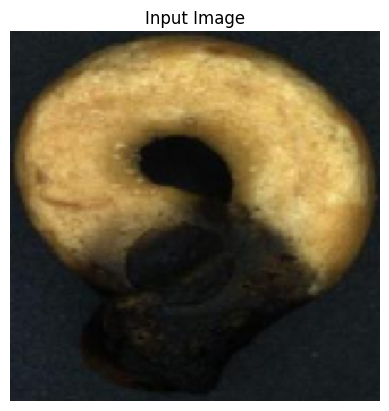

In [13]:
# Example usage
img_path = base_dir+'/Images/3354.jpg'
make_prediction(model, img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted class description: Defect_No


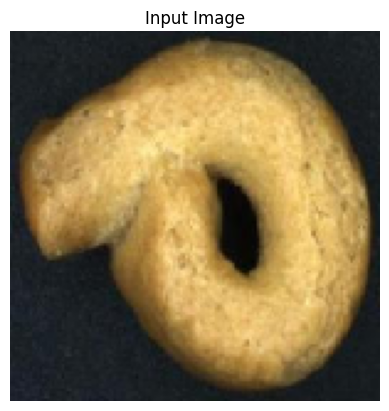

In [14]:
# Example usage
img_path = base_dir+'/Images/4449.jpg'
make_prediction(model, img_path)

# **Shortcomings and Possible Future Improvements**

## Shortcomings:

**Limited Dataset:** The dataset might not be large enough to capture all possible variations and defects in biscuits.

**Augmentation Limitations:** Data augmentation might not perfectly simulate real-world variations and defects.

## Possible Future Improvements:

**Larger Dataset:** Collecting more data with diverse defect types to improve the model’s generalization.

**Advanced Architectures:** Experimenting with more advanced architectures like transfer learning using pre-trained models (e.g., ResNet, Inception) to leverage existing learned features.

**Anomaly Detection Techniques:** Integrating unsupervised anomaly detection techniques to detect new and unknown defects not present in the training data.

**Real-time Deployment:** Developing a real-time detection system for deployment on the production line to provide immediate feedback.
By addressing these shortcomings and implementing the suggested improvements, the model can achieve better performance and robustness in detecting anomalies in biscuits.